### 9) 전처리 자동화와 교차검증

In [ ]:
#   mean      정규분포
#   median    비정규분포
#   최빈수     범주형

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/40945

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

df=pd.concat([X,y],axis=1)
df

c:\Python3.9.13\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN,0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN,0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN,0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN,0


In [2]:
df.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'survived'],
      dtype='object')

In [3]:
train_cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

X = df[train_cols] # 독립변수
y = df["survived"]

y.value_counts()

survived
0    809
1    500
Name: count, dtype: int64

In [20]:
#! pip install missingno

<Axes: >

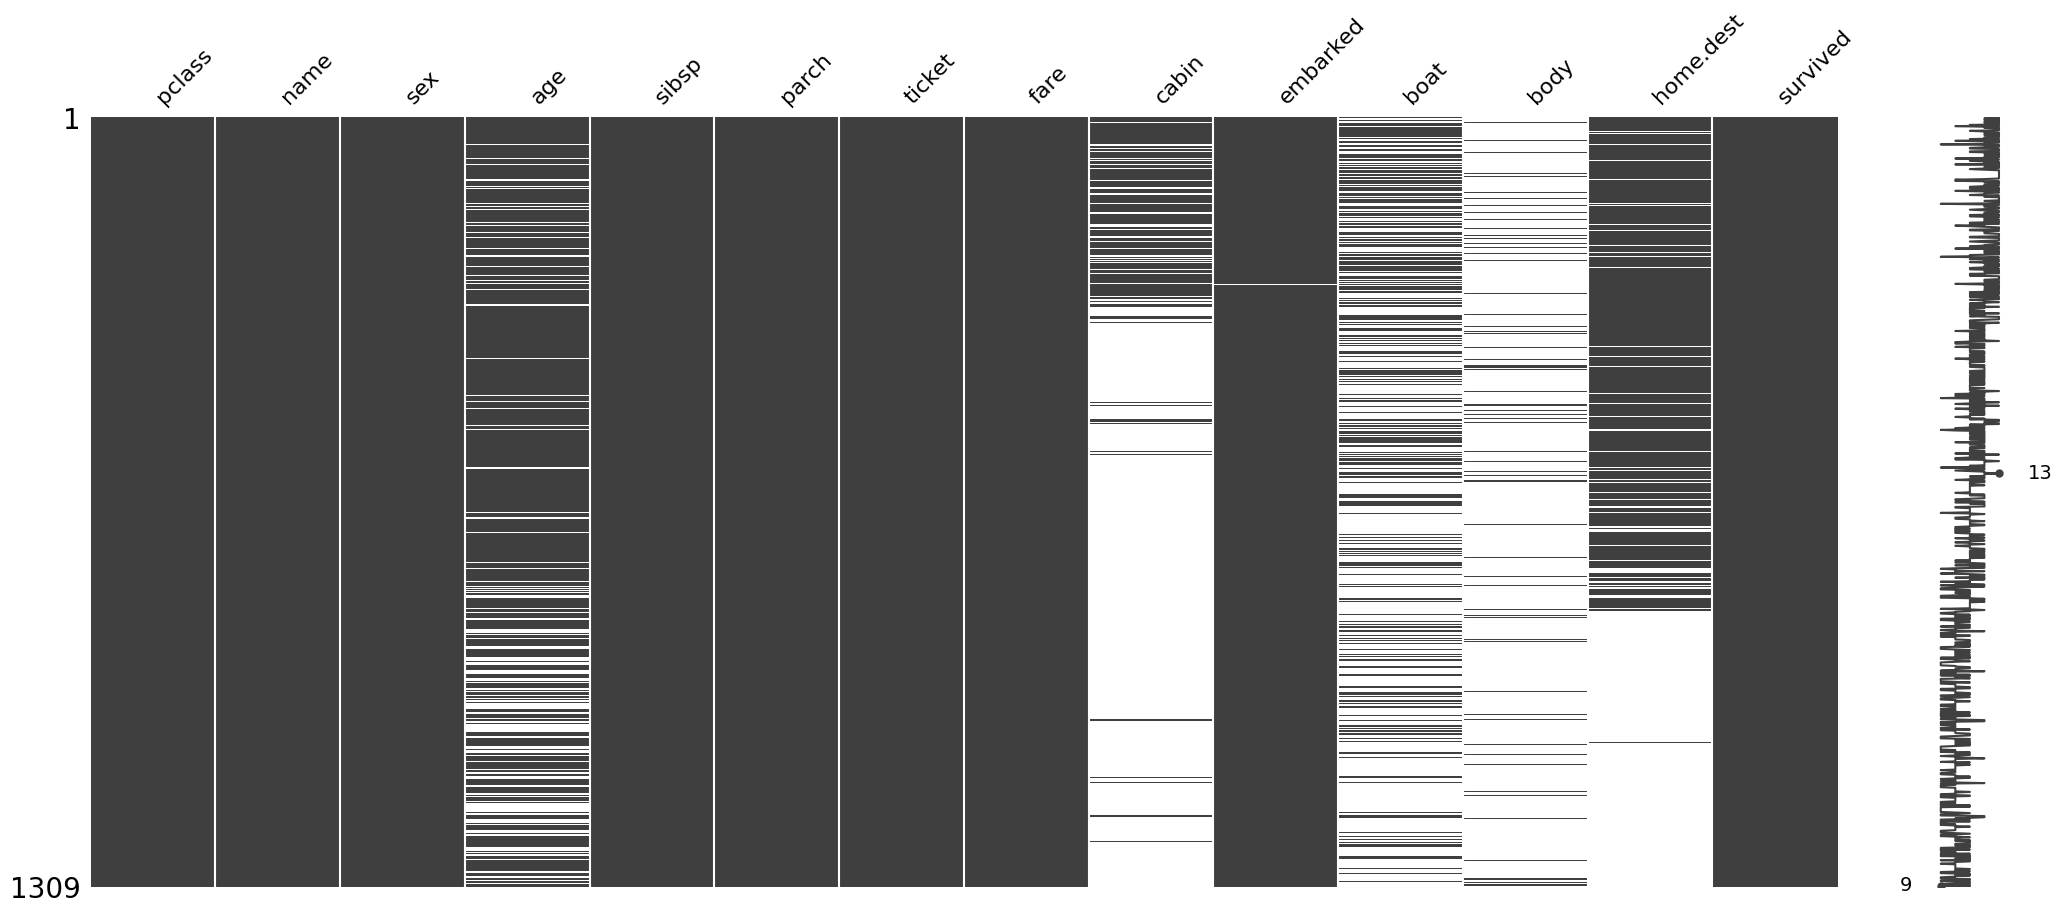

In [21]:
import missingno as msno
msno.matrix(df)

<Axes: >

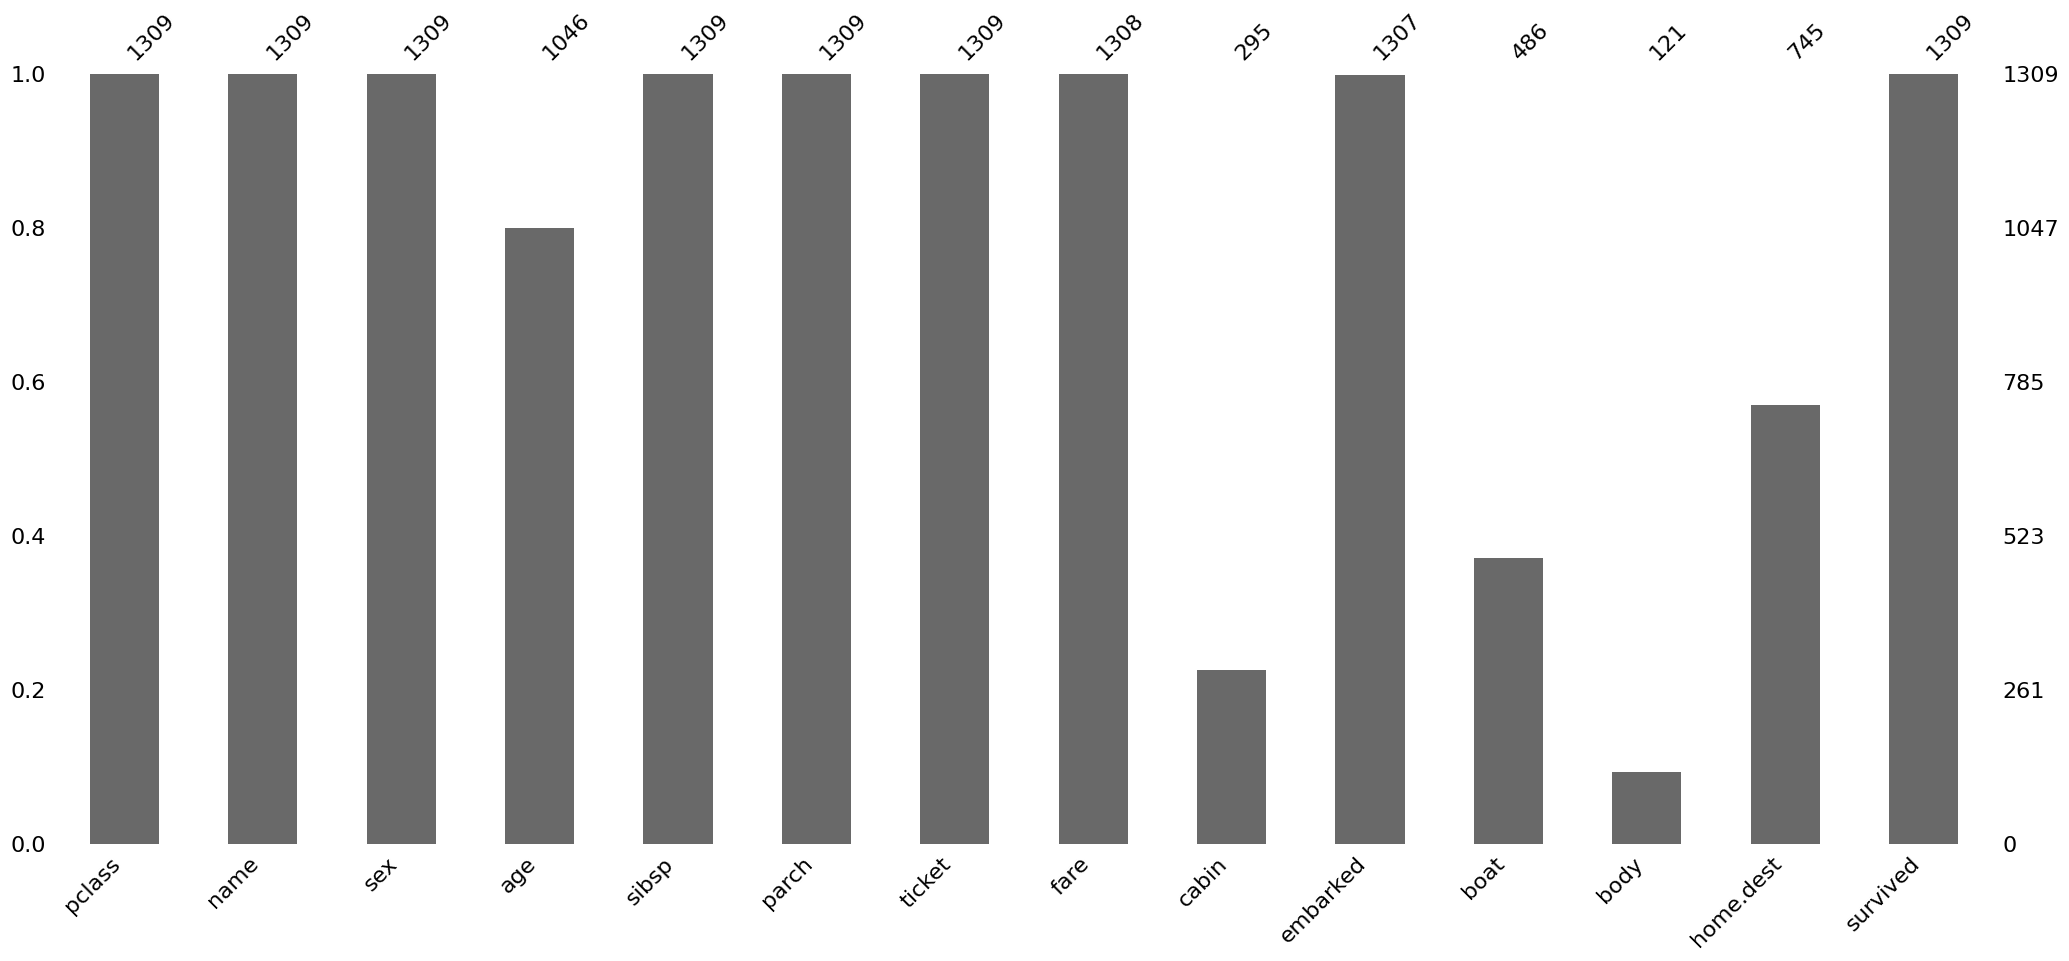

In [22]:
msno.bar(df) #필드별 데이터 완성도

<Axes: xlabel='survived', ylabel='count'>

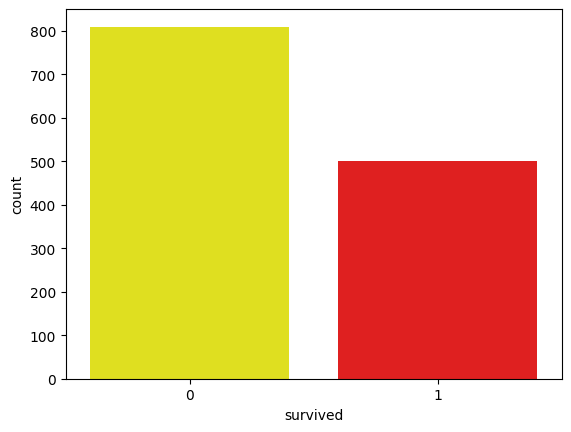

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["yellow", "red"]

sns.countplot(x='survived', data=df, palette=colors)

In [6]:
#언더샘플링

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['survived'])

df2=pd.concat([X_samp,y_samp],axis=1)
df2.survived.value_counts()

survived
0    500
1    500
Name: count, dtype: int64

In [7]:
X = df2[train_cols] # 독립변수
y = df2["survived"]

<Axes: xlabel='survived', ylabel='count'>

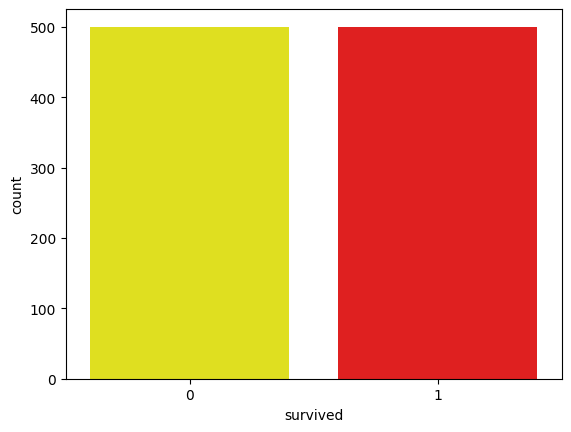

In [10]:
colors = ["yellow", "red"]

sns.countplot(x='survived', data=df2, palette=colors)

In [11]:
X = X_samp[train_cols] # 독립변수
y = y_samp["survived"]

In [12]:
#데이터 전처리 자동화
#연속된 변환을 순서대로 처리하는 클래스

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

#결측값 처리 - 나이, 요금(중위수로 처리)
#스케일링                                                            #     most_frequent
numeric_features = ['age', 'fare']                                  #     median
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                      ('scaler', StandardScaler())])

#범주형 변수 - 원핫인코딩
# embarked: {'C', 'S', 'Q'}
# sex: {'female', 'male'}
# pclass: {1, 2, 3}
# handle_unknown='ignore'  변환 중에 에러가 발생할 경우 무시하고 계속 진행
categorical_features = ['embarked', 'sex', 'pclass']

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

# 전처리 후 로지스틱 회귀분석 분류모형
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.76625
0.775


In [14]:
#교차검증과 모형의 튜닝
#하이퍼 파라미터 최적화

from sklearn.model_selection import GridSearchCV

# 숫자 결측값 처리
# Cost
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
#          변수명__num__imputer__strategy
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
#                                             교차검증횟수
grid_search.fit(X, y)
grid_search.cv_results_["params"]

[{'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 100, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 100, 'prep

In [15]:
scores=grid_search.cv_results_["mean_test_score"]
scores

array([0.727, 0.728, 0.748, 0.748, 0.75 , 0.75 , 0.754, 0.75 , 0.754,
       0.753, 0.754, 0.753, 0.754, 0.753])

In [25]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7540000000000001
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}


0.7540000000000001


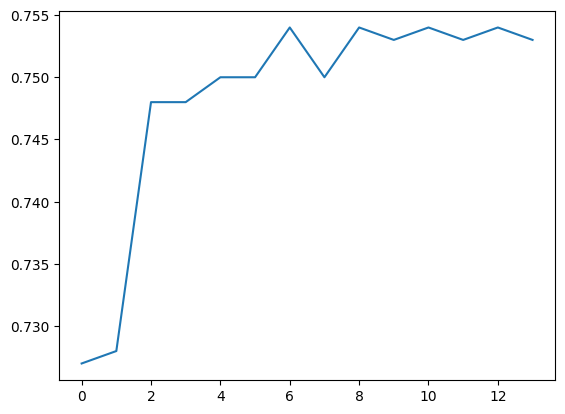

In [16]:
print(max(scores))
plt.plot(scores)

In [17]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7540000000000001
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}
